## **Tutorial: Brain MRI Image Prediction
1. Getting image data in, preprocessing it, and fitting a model



In [2]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3



In [7]:
# After saving the following zip file to your working directory extract all files and folders from zip file to local folder.

!unzip brain_tumor_dataset.zip  


Archive:  brain_tumor_dataset.zip
   creating: brain_tumor_dataset/no/
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brai

In [3]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y89.JPG', 'brain_tumor_dataset/yes/Y192.JPG', 'brain_tumor_dataset/yes/Y62.jpg', 'brain_tumor_dataset/yes/Y164.JPG', 'brain_tumor_dataset/yes/Y49.JPG', 'brain_tumor_dataset/yes/Y188.jpg', 'brain_tumor_dataset/yes/Y25.jpg', 'brain_tumor_dataset/yes/Y98.JPG', 'brain_tumor_dataset/yes/Y6.jpg', 'brain_tumor_dataset/yes/Y81.jpg', 'brain_tumor_dataset/yes/Y23.JPG', 'brain_tumor_dataset/yes/Y11.jpg', 'brain_tumor_dataset/yes/Y242.JPG', 'brain_tumor_dataset/yes/Y113.JPG', 'brain_tumor_dataset/yes/Y60.jpg', 'brain_tumor_dataset/yes/Y54.jpg', 'brain_tumor_dataset/yes/Y258.JPG', 'brain_tumor_dataset/yes/Y257.jpg', 'brain_tumor_dataset/yes/Y147.JPG', 'brain_tumor_dataset/yes/Y16.JPG', 'brain_tumor_dataset/yes/Y71.JPG', 'brain_tumor_dataset/yes/Y32.jpg', 'brain_tumor_dataset/yes/Y92.jpg', 'brain_tumor_dataset/yes/Y37.jpg', 'brain_tumor_dataset/yes/Y99.JPG', 'brain_tumor_dataset/yes/Y107.jpg', 'brain_tumor_dataset/yes/Y21.jpg',

In [4]:
# Let's explore the details of the image data using load_img from keras
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# It's an RGB image, so we can import using the following approach.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(preprocessor, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model


In [7]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min().round() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

253
(224, 224, 3)
-0.0
1.0


(253, 224, 224, 3)

In [8]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


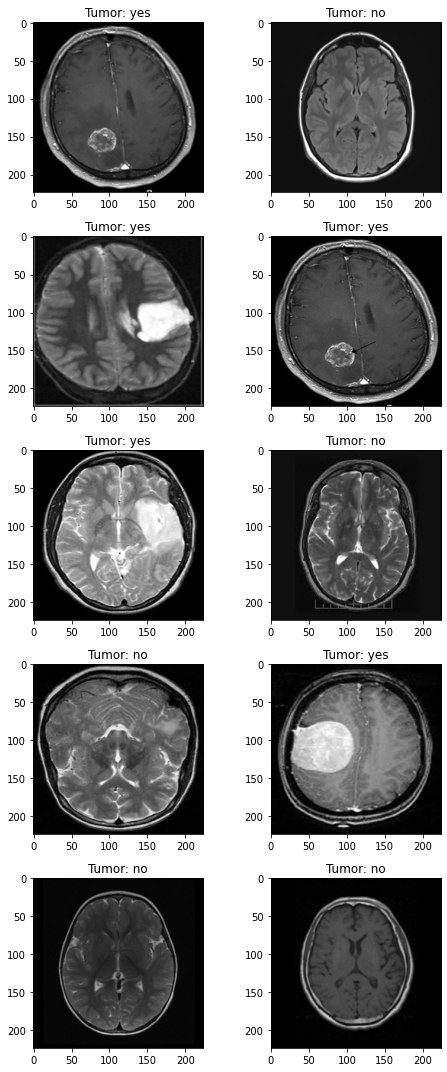

In [9]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

In [50]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.50,random_state=42)


y_train 



,no,yes
158,1,0
182,1,0
178,1,0
98,0,1
36,0,1
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


## Back to example code for Keras Convolutional Neural Net:

In [11]:
# Let's set a baseline plain vanilla network model to use as a baseline for convnet models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(learning_rate=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 

  
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/5
4/4 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.5238
Epoch 00001: val_accuracy improved from -inf to 0.63780, saving model to best_model.h5
4/4 [==============================] - 5s 388ms/step - loss: 0.6615 - accuracy: 0.5238 - val_loss: 0.6188 - val_accuracy: 0.6378 - lr: 0.0010
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.6587
Epoch 00002: val_accuracy did not improve from 0.63780
4/4 [==============================] - 1s 251ms/step - loss: 0.6190 - accuracy: 0.6587 - val_loss: 0.5961 - val_accuracy: 0.6378 - lr: 0.0010
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.6508
Epoch 00003: val_accuracy improved from 0.63780 to 0.67717, saving model to best_model.h5
4/4 [==============================] - 1s 274ms/step - loss: 0.6023 - accuracy: 0.6508 - val_loss: 0.5915 - val_accuracy: 0.6772 - lr: 0.0010
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 0.57

In [40]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

   model = tf.keras.Sequential([
      # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      # classifying into 2 categories
      tf.keras.layers.Dense(2, activation='softmax')
    ])
    #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
    #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

   model.compile(
      optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
      loss= 'categorical_crossentropy',
      metrics=['accuracy'])
    
    # Fitting the CNN to the Training set
   model.fit(X_train, y_train, 
                      epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
4/4 [==============================] - 11s 586ms/step - loss: 0.6878 - accuracy: 0.5635 - val_loss: 0.6589 - val_accuracy: 0.6378
Epoch 2/5
4/4 [==============================] - 0s 98ms/step - loss: 0.6297 - accuracy: 0.5873 - val_loss: 0.5931 - val_accuracy: 0.6378
Epoch 3/5
4/4 [==============================] - 0s 96ms/step - loss: 0.5579 - accuracy: 0.6905 - val_loss: 0.6321 - val_accuracy: 0.6614
Epoch 4/5
4/4 [==============================] - 0s 96ms/step - loss: 0.4754 - accuracy: 0.7778 - val_loss: 0.6641 - val_accuracy: 0.6535
Epoch 5/5
4/4 [==============================] - 0s 96ms/step - loss: 0.5131 - accuracy: 0.7381 - val_loss: 0.7083 - val_accuracy: 0.6535


In [41]:
model.history.epoch

[0, 1, 2, 3, 4]

## Submit a model to AI Model Share Competition

In [ ]:
!pip install aimodelshare --upgrade

### Restart runtime after installing (Runtime > Restart Runtime)

In [13]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [12]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [26]:
apiurl='https://r4lkmt378i.execute-api.us-east-2.amazonaws.com/prod/m'
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [31]:
#Submit Model 1: 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)



4/4 [==============================] - 0s 71ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 2

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3336


In [32]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,flatten_layers,dense_layers,relu_act,softmax_act,loss,optimizer,memory_size,username,version
0,70.08%,65.78%,67.37%,65.27%,keras,False,True,Sequential,5,6431106,1,4,3,1,str,SGD,25725520,mikedparrott,1
1,70.08%,65.78%,67.37%,65.27%,keras,False,True,Sequential,5,6431106,1,4,3,1,str,SGD,25725520,mikedparrott,2


In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

## Experiment with different model architectures:
1. Submit at least two models using fully connected layers only
2. Submit at least two models that use convolution layers without transfer learning
3. Submit one or more models that use transfer learning

## Augment Image Data Using Keras ImageDataGenerator()



In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Let's try it with the brain MRI data:

###Load list of image file paths and list of y labels into two columns of an X_train dataframe


In [36]:
# This time we will load images from the original list of filenames, but we will not preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

filenamelist=fnames[0]+fnames[1]
len(filenamelist)

253

In [37]:
# Create y data labelsmade up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))


#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
len(y_labels) 



253

In [48]:
# Train test split file names and labels
from sklearn.model_selection import train_test_split

X_train_datagen,X_test_datagen,y_train_datagen,y_test_datagen=train_test_split(filenamelist,y_labels,test_size=0.40,random_state=42)

print(X_train_datagen[0:5])
y_train_datagen[0:5] 

['brain_tumor_dataset/no/no 96.jpg', 'brain_tumor_dataset/no/26 no.jpg', 'brain_tumor_dataset/yes/Y1.jpg', 'brain_tumor_dataset/no/36 no.jpg', 'brain_tumor_dataset/yes/Y38.jpg']


['no', 'no', 'yes', 'no', 'yes']

In [49]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()

,X,y
0,brain_tumor_dataset/no/no 96.jpg,no
1,brain_tumor_dataset/no/26 no.jpg,no
2,brain_tumor_dataset/yes/Y1.jpg,yes
3,brain_tumor_dataset/no/36 no.jpg,no
4,brain_tumor_dataset/yes/Y38.jpg,yes


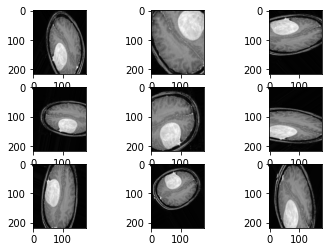

In [40]:
# example of image augmentation for single image
# see more options here: https://keras.io/preprocessing/image/
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img("brain_tumor_dataset/yes/Y1.jpg")
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
        zoom_range=0.5,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [41]:

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,

        horizontal_flip=True,
        vertical_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary',shuffle=True)


Found 151 validated image filenames belonging to 2 classes.


In [42]:

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary')



Found 102 validated image filenames belonging to 2 classes.


In [44]:
#Build a model to fit below
opt=SGD(learning_rate=.001)

model = Sequential()
model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
                                            
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


      # fits the model on batches with real-time data augmentation:
      model.fit(train_generator,
                    steps_per_epoch=len(trainingdata) / 1, epochs=10, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
                    validation_data=validation_generator)

Epoch 1/10
151/151 [==============================] - 4s 29ms/step - loss: 0.6199 - accuracy: 0.6821 - val_loss: 0.6417 - val_accuracy: 0.6373
Epoch 2/10
151/151 [==============================] - 3s 22ms/step - loss: 0.6292 - accuracy: 0.6159 - val_loss: 0.5949 - val_accuracy: 0.7255
Epoch 3/10
151/151 [==============================] - 3s 21ms/step - loss: 0.6193 - accuracy: 0.6291 - val_loss: 0.5836 - val_accuracy: 0.7647
Epoch 4/10
151/151 [==============================] - 6s 42ms/step - loss: 0.6463 - accuracy: 0.6623 - val_loss: 0.6018 - val_accuracy: 0.7451
Epoch 5/10
151/151 [==============================] - 4s 28ms/step - loss: 0.5912 - accuracy: 0.7020 - val_loss: 0.5711 - val_accuracy: 0.7255
Epoch 6/10
151/151 [==============================] - 3s 23ms/step - loss: 0.6031 - accuracy: 0.6623 - val_loss: 0.5981 - val_accuracy: 0.6863
Epoch 7/10
151/151 [==============================] - 3s 21ms/step - loss: 0.6320 - accuracy: 0.7086 - val_loss: 0.5778 - val_accuracy: 0.6961

In [52]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model_2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [53]:
# Submit Model

#-- Generate predicted y values (Model 2)
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model_2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

4/4 [==============================] - 0s 70ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 3

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3336


In [54]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,flatten_layers,dense_layers,sigmoid_act,relu_act,softmax_act,loss,optimizer,memory_size,username,version
0,70.08%,65.78%,67.37%,65.27%,keras,False,True,Sequential,5,6431106,1,4,nan,3,1.000000,str,SGD,25725520,mikedparrott,1
1,70.08%,65.78%,67.37%,65.27%,keras,False,True,Sequential,5,6431106,1,4,nan,3,1.000000,str,SGD,25725520,mikedparrott,2
2,36.22%,26.59%,18.11%,50.00%,keras,False,True,Sequential,5,3219841,1,4,1.000000,3,nan,str,SGD,12880464,mikedparrott,3
